# Module 19- Metropolis Monte Carlo

<img src='https://c.o0bg.com/rf/image_960w/Boston/2011-2020/2015/06/03/BostonGlobe.com/Arts/Images/24w.jpg', width=600px>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
%matplotlib notebook

### Ising Model of Ferromagnatism

Measuring energies in units where $J=k_{\rm B} = 1$ we can write the Ising model Hamiltonian:

\begin{equation}
H = - \sum_{\langle i,j\rangle } s_i s_j
\end{equation}

where $s_i = \pm 1$ and $\langle i,j \rangle$ means that sites $i$ and $j$ are nearest neighbors.  Let's consider a $N = L \times L$ square lattice in $d=2$ with periodic boundary conditions.  This is equivalent to wrapping our lattice onto the surface of a torus.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Torus_from_rectangle.gif" width=400px>

In two dimensions, our *spin* array $s_i$ can be written as a matrix:

<div class="span alert alert-success">
<h2> Programming challenge </h2>
Complete the function that initializes the 2d spin lattice for the Ising model.
</div>

<IPython.core.display.Javascript object>


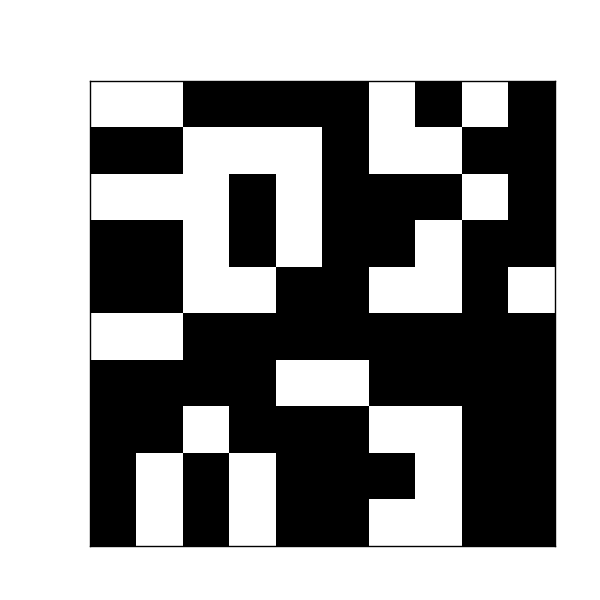

[[ 1  1 -1 -1 -1 -1  1 -1  1 -1]
 [-1 -1  1  1  1 -1  1  1 -1 -1]
 [ 1  1  1 -1  1 -1 -1 -1  1 -1]
 [-1 -1  1 -1  1 -1 -1  1 -1 -1]
 [-1 -1  1  1 -1 -1  1  1 -1  1]
 [ 1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1  1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  1  1 -1 -1]
 [-1  1 -1  1 -1 -1 -1  1 -1 -1]
 [-1  1 -1  1 -1 -1  1  1 -1 -1]]


In [2]:
def initialize_config(L):
    '''Initialize a random spin configuration'''

    s = np.ones([L,L],dtype=int)
    s[np.random.random([L,L])<=0.5] = -1
    return s


L = 10
s = initialize_config(L)

# visualize
plt.matshow(s, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);
print(s)

In terms of this matrix, the energy can be written as:

\begin{equation}
E = - \frac{1}{2}\sum_{i=0}^{L-1} \sum_{j=0}^{L-1} s[i,j]\left(s[i+1,j] + s[i-1,j] + s[i,j+1] + s[i,j-1]\right)
\end{equation}

How do we deal with the periodic boundary conditions?

In [3]:
p1 = np.arange(1,L+1)
p1[-1] = 0
m1 = np.arange(-1,L-1)

print(p1)
print(m1)

[1 2 3 4 5 6 7 8 9 0]
[-1  0  1  2  3  4  5  6  7  8]


<div class="span alert alert-success">
<h2> Programming challenge </h2>
Complete the function that computes the energy $E$ and magnetization $M$ of a 2d Ising model.
</div>

In [4]:
def get_props(s):
    '''The energy E and magnetization M for a microstate of the 2d Ising model.'''
    E = 0.0
    M = s.sum()
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            E -= s[i,j] * (s[p1[i],j] + s[m1[i],j] + s[i,p1[j]] + s[i,m1[j]])
    return E,M

E,M = get_props(s)
print('E = {0}, M = {1}'.format(E,M))

E = -24.0, M = -28


## Monte Carlo Update

An update consists of flipping an individual spin and we need to determine the change in energy.  Suppose we flip the spin with index $k,\ell$, then: $s'[k,\ell] = -s[k,\ell]$ and we can write:

\begin{align*}
\Delta E &= E' - E \newline
&= 2s[k,\ell]\left(s[k+1,\ell] + s[k-1,\ell] + s[k,\ell+1] + s[k,\ell-1]\right).
\end{align*}

and 

\begin{equation}
\Delta M = 2 s[k,\ell]
\end{equation}

and thus the acceptance probability for the move will be:

\begin{equation}
P_{\rm acc} = \mathrm{e}^{-\Delta E/T}.
\end{equation}

Each Monte Carlo update consists of:

1. Select a random spin to flip with equal probability
2. Calculate $\Delta E$
3. Generate a uniform random number $r \in \mathcal{U}_{[0,1)}$
4. Perform the Metropolis test
    - If $r < \mathrm{e}^{-\Delta E/T}$: accept the move
    - Otherwise: do nothing
5. Measure the magnetization

A Monte Carlo **step** consists of $N=L^2$ updates.

<div class="span alert alert-success">
<h2> Programming challenge </h2>
Complete the function that computes a montecarlo step for the 2d Ising model.
</div>

In [5]:
def monte_carlo_step(s,T):
    '''Perform a Monte Carlo step.'''
    
    # get the current magnetization
    M = s.sum()
    
    # attempt L^2 spin flips
    for update in range(s.size):
        
        # choose a random lattice point to flip
        k = np.random.randint(0,s.shape[0])
        l = np.random.randint(0,s.shape[1])
        
        # calculate the change in energy
        dE = 2*s[k,l]*(s[p1[k],l] + s[m1[k],l] + s[k,p1[l]] + s[k,m1[l]])
        
        # perform the Metropolis test
        if np.random.random() <= np.exp(-dE/T):
            s[k,l] *= -1

            # Update the magnetization
            M += 2*s[k,l]
    
    return M

### Monte Carlo Simulation

A simulation consists of performing a large number of Monte Carlo steps at each temperature starting from some random initial configuration.

In [6]:
# temperatures to consider
T = np.arange(0.2,5.0,0.2)

# number of Monte Carlo steps we will perform
num_steps = 100

# magnetization for each temperature
M = np.zeros([num_steps,T.size])
# initialize
L = 10
s = initialize_config(L)

# create PBC lookup tables
p1 = np.arange(1,L+1)
p1[-1] = 0
m1 = np.arange(-1,L-1)

# Loop over temperatures from high to low
for iT,cT in enumerate(T[::-1]):
    m = T.size - 1 - iT
    
    # initialize the magnetization
    M[0,m] = s.sum()
    
    # Perform the Monte Carlo steps
    for step in range(1,num_steps):
        M[step,m] = monte_carlo_step(s,cT)

## Observing the  results

<IPython.core.display.Javascript object>


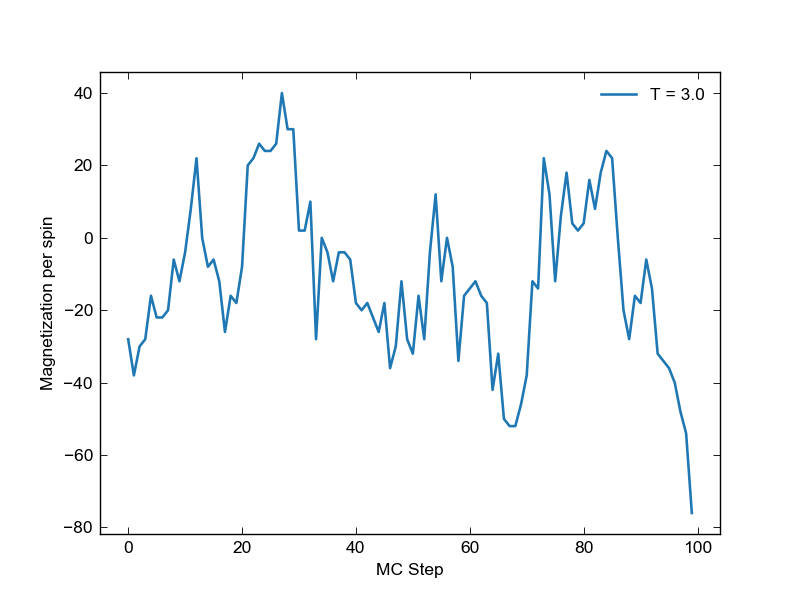

In [7]:
iT = 14
plt.figure()
plt.plot(M[:,iT],'-', label='T = %3.1f' %T[iT])
plt.legend()
plt.xlabel('MC Step')
plt.ylabel('Magnetization per spin')

## Analyzing the results

We want to compute the average value at each temperature, but we need to skip some number of initial measurements as the system make time some *time* to equilibrate.

In [8]:
skip = 10
m = np.average(M[skip:]/L**2,axis=0)
δm = np.std(M[skip:]/L**2,axis=0)/np.sqrt(num_steps-skip)

<IPython.core.display.Javascript object>


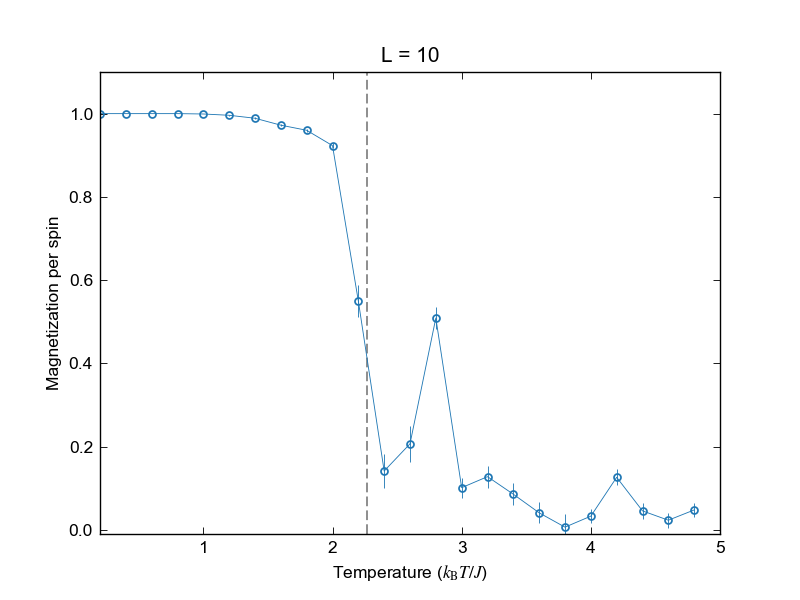

In [9]:
plt.figure()
plt.errorbar(T,np.abs(m),yerr=δm, linewidth=0.5, marker='o', markerfacecolor='None', markersize=4, elinewidth=0.5)
plt.axvline(x=2.0/np.log(1.0+np.sqrt(2.0)), linewidth=1, color='0.5', linestyle='--')
plt.xlim(0.2,5)
plt.ylim(-0.01,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 10")

## Load some data for a *much* longer run and $L=32$ from disk and compare with the exact Onsager solution

\begin{equation}
M=\left(1-\left[\sinh \frac{2J}{k_{\rm B}T}\right]^{-4}\right)^{\frac {1}{8}}
\end{equation}

In [10]:
def magnetization_exact_(T):
    '''We use units where J/k_B = 1.'''
    Tc = 2.0/np.log(1.0+np.sqrt(2.0))
    if T < Tc:
        return (1.0 - np.sinh(2.0/T)**(-4))**(1.0/8)
    else:
        return 0.0
magnetization_exact = np.vectorize(magnetization_exact_)

<IPython.core.display.Javascript object>


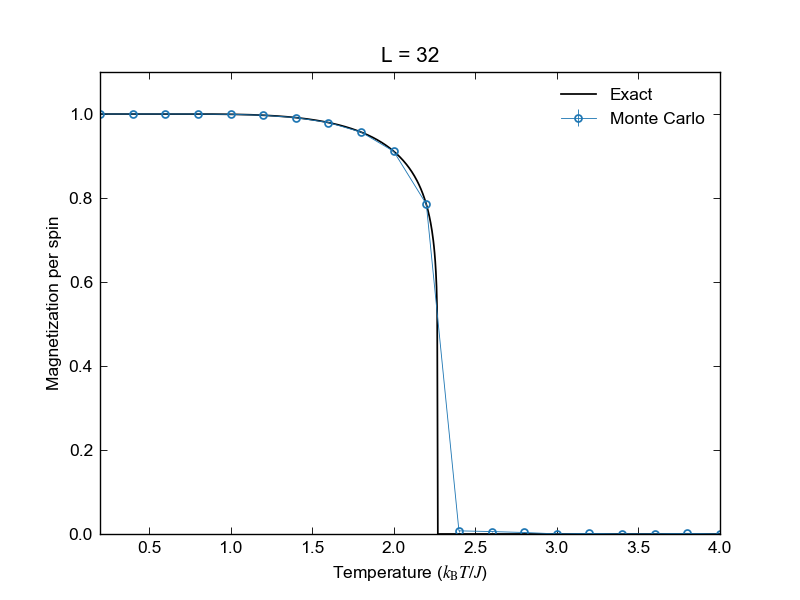

In [11]:
data = np.loadtxt('data/Ising_estimators_032.dat')
lT = np.linspace(0.01,4,1000)
lL = 32

plt.figure()
plt.plot(lT,magnetization_exact(lT),'-k', linewidth=1, label='Exact')
plt.errorbar(data[:,0],np.abs(data[:,5])/lL**2,yerr=data[:,6]/lL**2, linewidth=0.5, marker='o', 
             markerfacecolor='None', markersize=4, elinewidth=0.5, label='Monte Carlo')
plt.xlim(0.2,4)
plt.ylim(0,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 32")
plt.legend()